# Problem 4.1: KIMIA image alignment

We are given a dataset of 2D images at some angle. We need to rotate them so that they align with the target image.

In [2]:
import numpy as np
from PIL import Image
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Loading the data

We use the scripts given in q1 to load the data. 

In [3]:
dataset_dir = 'KIMIA dataset'

opt = {
    'image_size': 256,
    'is_grayscale': True
}

In [4]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    # im = im.resize((opt['image_size'], opt['image_size']))
    im = np.array(im)
    return im

def display_images(imgs,row=1,col=2,w=opt['image_size'],h=opt['image_size']):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, min(len(imgs) + 1, col*row +1)):
        img = imgs[i-1]
        img_pil = Image.fromarray(img)
        img_pil = img_pil.resize((w, h), Image.BILINEAR)
        img = np.array(img_pil)
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            image_list.append(im)
        else:
            continue
    print("Number of images : {}".format(len(image_list)))

    return image_list

In [5]:
X = load_data(dataset_dir)

Number of images : 99


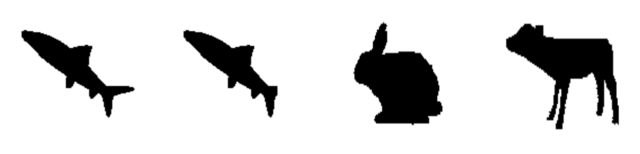

In [6]:
display_images(X[0:4],row=1,col=4)

The images in the dataset look like the ones above. There are 99 such images. 

The image selected in the cell below will be our target image. The rest of the images will have to be aligned to this.

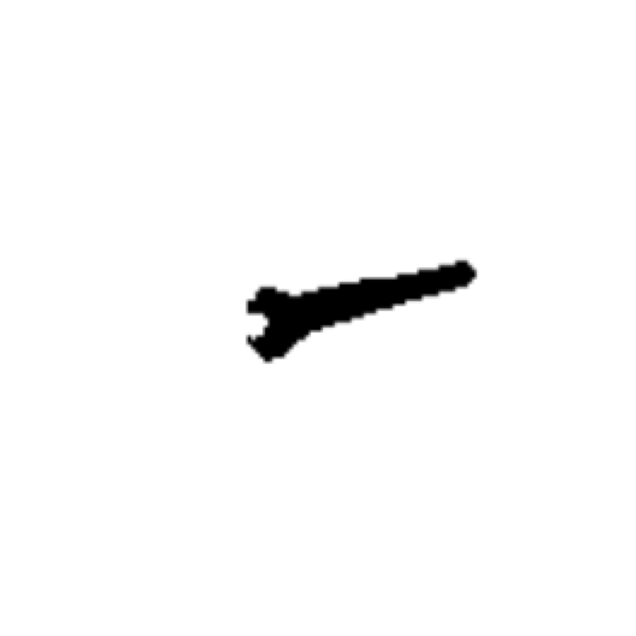

In [7]:
target_image = X[96]
display_images([target_image],row=1,col=1)

## The Alignment Algorithm

To achieve this rotation, we need to find an image's axis of alignment. We formulate the axis of alignment of a 2D image to be the line of least squares or the line with maximised variance (they refer to the same line).

To find this line and hence the angle of alignment, we use PCA and a heuristic with the mean of the coordinates. The algorithm is as follows:
1. Load all images in a list of numpy arrays.

2. Convert all images into single channel made of only 2 values (255 or 0) using a threshold. This will give the object of interest.

3. Create a dataset containing the coordinates (x, y) of all pixels with a value of 1 or 0 in the binary image. In our case the object is made up of 0s and the background is made up of 1s. So we take the coordinates of the 0s.

4. Calculate the pca components of this dataset. The component with the highest variance is the axis of alignment.
    If the explained variance of both components are close, the axis of alignment is not clear. In this case, we use a heuristic with the mean of the coordinates to find the correct axis of alignment. The mean of the coordinates should align with axis of alignment. If it doesn't, we use the other component as the axis of alignment.

5. Find the angle (θ) of the axis of alignment with respect to the horizontal axis (x-axis). This is done using np.arctan.

6. Load the target image and find the angle (α) of the axis of alignment of the target image.

7. For each image in the dataset:
   - Take the angle of the axis of alignment of the image (θ) and the angle of the axis of alignment of the target image (α).
   - Calculate the difference between ϕ and θ.
   - Rotate the image by the difference angle to align it with the template image.

9. The dataset should be aligned to the target image now. Plot the images in a 10x10 plot.

In [8]:
def find_coordinates(image, threshold=0.5):
    coords = []
    h, w = image.shape
    for i in range(h):
        for j in range(w):
            if image[i,j] < threshold * 255.0:
                coords.append([j,h - i])
    coords = np.array(coords)
    return coords

def find_angle(image):
    # find angle of axis of alignment wrt to x-axis.
    coords = find_coordinates(image)
    pca = PCA(n_components=2)
    pca.fit(coords)
    v = pca.components_[0]
    angle = np.arctan(v[1]/v[0])  
    
    # Heuristic to find the correct angle using mean
    mean_coord = np.mean(coords,axis=0)
    h, w = image.shape
    angle_mean = np.arctan((mean_coord[1] - h/2.0)/(mean_coord[0] - w/2.0))
    if pca.explained_variance_ratio_[0] < 0.53 and abs(angle_mean - angle) > 1:
        v = pca.components_[1]
        angle = np.arctan(v[1]/v[0])
    
    # Heuristic for antiparallel - not working
    if mean_coord[0] < w/2.0 and mean_coord[1] < h/2.0:
        angle = angle - np.pi
    if mean_coord[0] < w/2.0 and mean_coord[1] > h/2.0:
        angle = angle + np.pi
    
    return angle

def rotate_image(image,angle):
    image = Image.fromarray(image)
    image = image.rotate(angle, fillcolor='white')
    image = np.array(image)
    return image

def align_image(image,alpha, center=None):
    angle = find_angle(image)
    image = rotate_image(image,(alpha - angle)*180/np.pi)
    return image

Target angle (radians) : 0.24786181747542987
Target image:


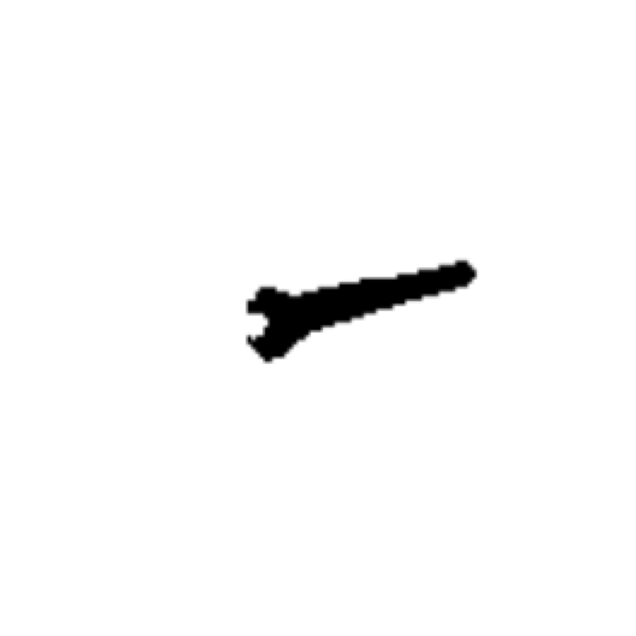

In [9]:
target_angle = find_angle(target_image)
print("Target angle (radians) : {}".format(target_angle))
print("Target image:")
display_images([target_image], row=1, col=1)

In [10]:
aligned_imgs = [None]*len(X)
for im, i in zip(X,range(len(X))):
    aligned_imgs[i] = align_image(im,target_angle)

## Results

Plotting the images in a 10x10 plot.

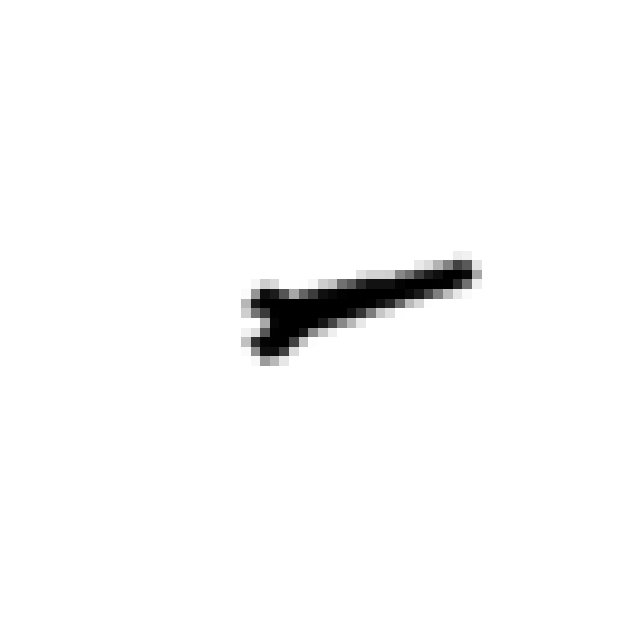

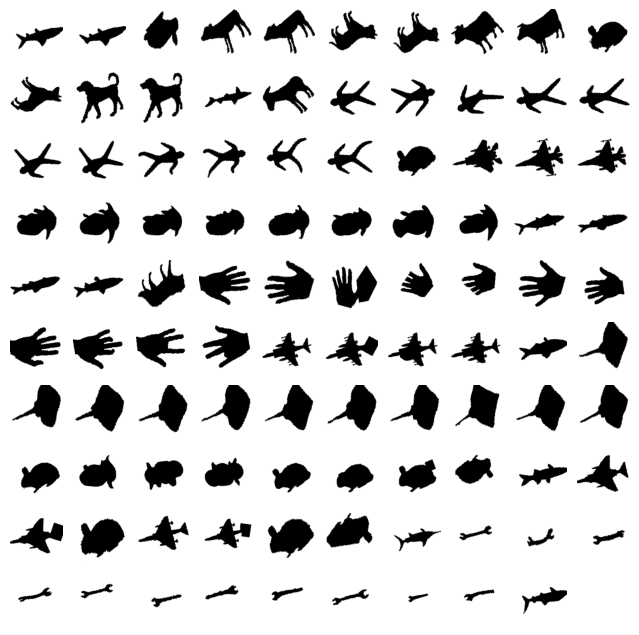

In [11]:
display_images([target_image],row=1,col=1, w=64, h=64)
display_images(aligned_imgs[0:len(X)],row=10,col=10)

As we can see all the images are aligned to the target image. The images are also resized to 64x64 for better visualization.

Some images are at a rotation of 180 degrees. This is because the axis of alignment is symmetrical for 180 degree rotations.